# 绘制中国东部逐小时或逐日的AQI站点观测数据，叠加风场(ERA5)

* Create: Evan
* Date: 2025-04-07

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader

In [50]:
era5_uv_path = '/data4/PUB_DATA_ALL/Reanalysis/ERA5/hourly_surface/100m_uv'
uv_file = os.path.join(era5_uv_path, 'ERA5_hourly_100m_uv_2024-08.nc')

aqi_path = '/data4/PUB_DATA_ALL/Observation/AQI_station'
aqi_file = os.path.join(aqi_path, '2024/AQI_2590A_2024.txt')

era5_uv = xr.open_dataset(uv_file)
aqi_data = pd.read_csv(aqi_file, sep=r'\s+',na_values='-999')


In [51]:
time = '2024-08-02T16'

era5_uv_data = era5_uv.sel(valid_time=time)

era5_uv_data


<xarray.Dataset> Size: 8MB
Dimensions:     (latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
    valid_time  datetime64[ns] 8B 2024-08-02T16:00:00
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      <U4 16B ...
Data variables:
    u100        (latitude, longitude) float32 4MB ...
    v100        (latitude, longitude) float32 4MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-13T14:09 GRIB to CDM+CF via cfgrib-0.9.1...

In [52]:
aqi_data['datetime'] = pd.to_datetime(aqi_data['Time'], format='%Y%m%d%H')
aqi_data = aqi_data.set_index('datetime').drop(columns=['Time'])

In [53]:
aqi_data['O3(ppb)'] = aqi_data['O3'] * 22.4 / 48
aqi_data['NO2(ppb)'] = aqi_data['NO2'] * 22.4 / 46
aqi_data['SO2(ppb)'] = aqi_data['SO2'] * 22.4 / 64
aqi_data['CO(ppm)'] = aqi_data['CO'] * 22.4 / 28

In [54]:
stationlist = pd.read_csv(os.path.join(aqi_path, 'stationlist.csv'))
stationlist.columns = ['stationID', 'name', 'city', 'lon', 'lat']
stationlist

,stationID,name,city,lon,lat
0,1001A,万寿西宫,北京,116.3660,39.8673
1,1002A,定陵,北京,116.1700,40.2865
2,1003A,东四,北京,116.4340,39.9522
3,1004A,天坛,北京,116.4340,39.8745
4,1005A,农展馆,北京,116.4730,39.9716
...,...,...,...,...,...
1628,3208A,市政府(20190313启用),忻州,112.7283,38.4153
1629,3207A,市政府原办公楼(20190308启用),滁州,118.3117,32.3039
1630,3209A,宁德一中(20190319启用),宁德,119.5228,26.6564
1631,3210A,汴京公园(20190322启用),开封,114.3644,34.7964


In [55]:
year = '2024'
month = '08'
time = '2024-08-02T16'

def generate_hourly_time_index(month_str):
    # 转换为该月的第一天零点
    start_date = pd.Timestamp(month_str)
    # 计算该月的总小时数
    total_hours = start_date.days_in_month * 24
    # 生成逐小时的时间索引
    hourly_index = pd.date_range(start=start_date, periods=total_hours, freq='h')
    return hourly_index

timeindex = generate_hourly_time_index(f'{year}-{month}')


In [56]:
year = '2024'
month = '08'
time = '2024-08-02T16'

timeindex = pd.date_range(start=f'{year}-{month}', end=f'{year}-{month}', freq='h')
pm25 = pd.DataFrame(index=timeindex, columns=stationlist['stationID'].tolist())
pm10 = pd.DataFrame(index=timeindex, columns=stationlist['stationID'].tolist())
so2 = pd.DataFrame(index=timeindex, columns=stationlist['stationID'].tolist())
no2 = pd.DataFrame(index=timeindex, columns=stationlist['stationID'].tolist())
co = pd.DataFrame(index=timeindex, columns=stationlist['stationID'].tolist())
o3 = pd.DataFrame(index=timeindex, columns=stationlist['stationID'].tolist())


In [57]:
timestamp = pd.Timestamp(time)
for i in stationlist['stationID']:
    aqi_csv_file = os.path.join(aqi_path, year, f'AQI_{i}_{year}.txt')
    if os.path.exists(aqi_csv_file):
        aqi_data = pd.read_csv(aqi_csv_file, sep=r'\s+', na_values='-999')
        aqi_data['datetime'] = pd.to_datetime(aqi_data['Time'], format='%Y%m%d%H')
        aqi_data = aqi_data.set_index('datetime').drop(columns=['Time'])
        aqi_data['O3(ppb)'] = aqi_data['O3'] * 22.4 / 48
        aqi_data['NO2(ppb)'] = aqi_data['NO2'] * 22.4 / 46
        aqi_data['SO2(ppb)'] = aqi_data['SO2'] * 22.4 / 64
        aqi_data['CO(ppm)'] = aqi_data['CO'] * 22.4 / 28
        pm25.loc[timestamp, i] = aqi_data.loc[timestamp, 'PM2.5']
        pm10.loc[timestamp, i] = aqi_data.loc[timestamp, 'PM10']
        so2.loc[timestamp, i] = aqi_data.loc[timestamp, 'SO2(ppb)']
        no2.loc[timestamp, i] = aqi_data.loc[timestamp, 'NO2(ppb)']
        co.loc[timestamp, i] = aqi_data.loc[timestamp, 'CO(ppm)']
        o3.loc[timestamp, i] = aqi_data.loc[timestamp, 'O3(ppb)']


In [58]:
shapefilepath = '/data8/xuyf/data/shapefile/GS(2024)0650-SHP/'
sheng = Reader(shapefilepath + 'sheng.shp')
shiduanxian = Reader(shapefilepath + 'shiduanxian.shp')

In [59]:
def add_shapefile(ax):
    ax.add_feature(cfeature.ShapelyFeature(sheng.geometries(), ccrs.PlateCarree(), 
                                            facecolor='none', edgecolor='k'))
    ax.add_feature(cfeature.ShapelyFeature(shiduanxian.geometries(), ccrs.PlateCarree(), 
                                           facecolor='none', edgecolor='k'))
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    
    gl = ax.gridlines(
    xlocs=np.arange(-180, 180 + 1, 2), ylocs=np.arange(-90, 90 + 1, 2),
    draw_labels=True, x_inline=False, y_inline=False,
    linewidth=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False
    gl.rotate_labels = False
    gl.xlabel_style = {'size': 18}
    gl.ylabel_style = {'size': 18}

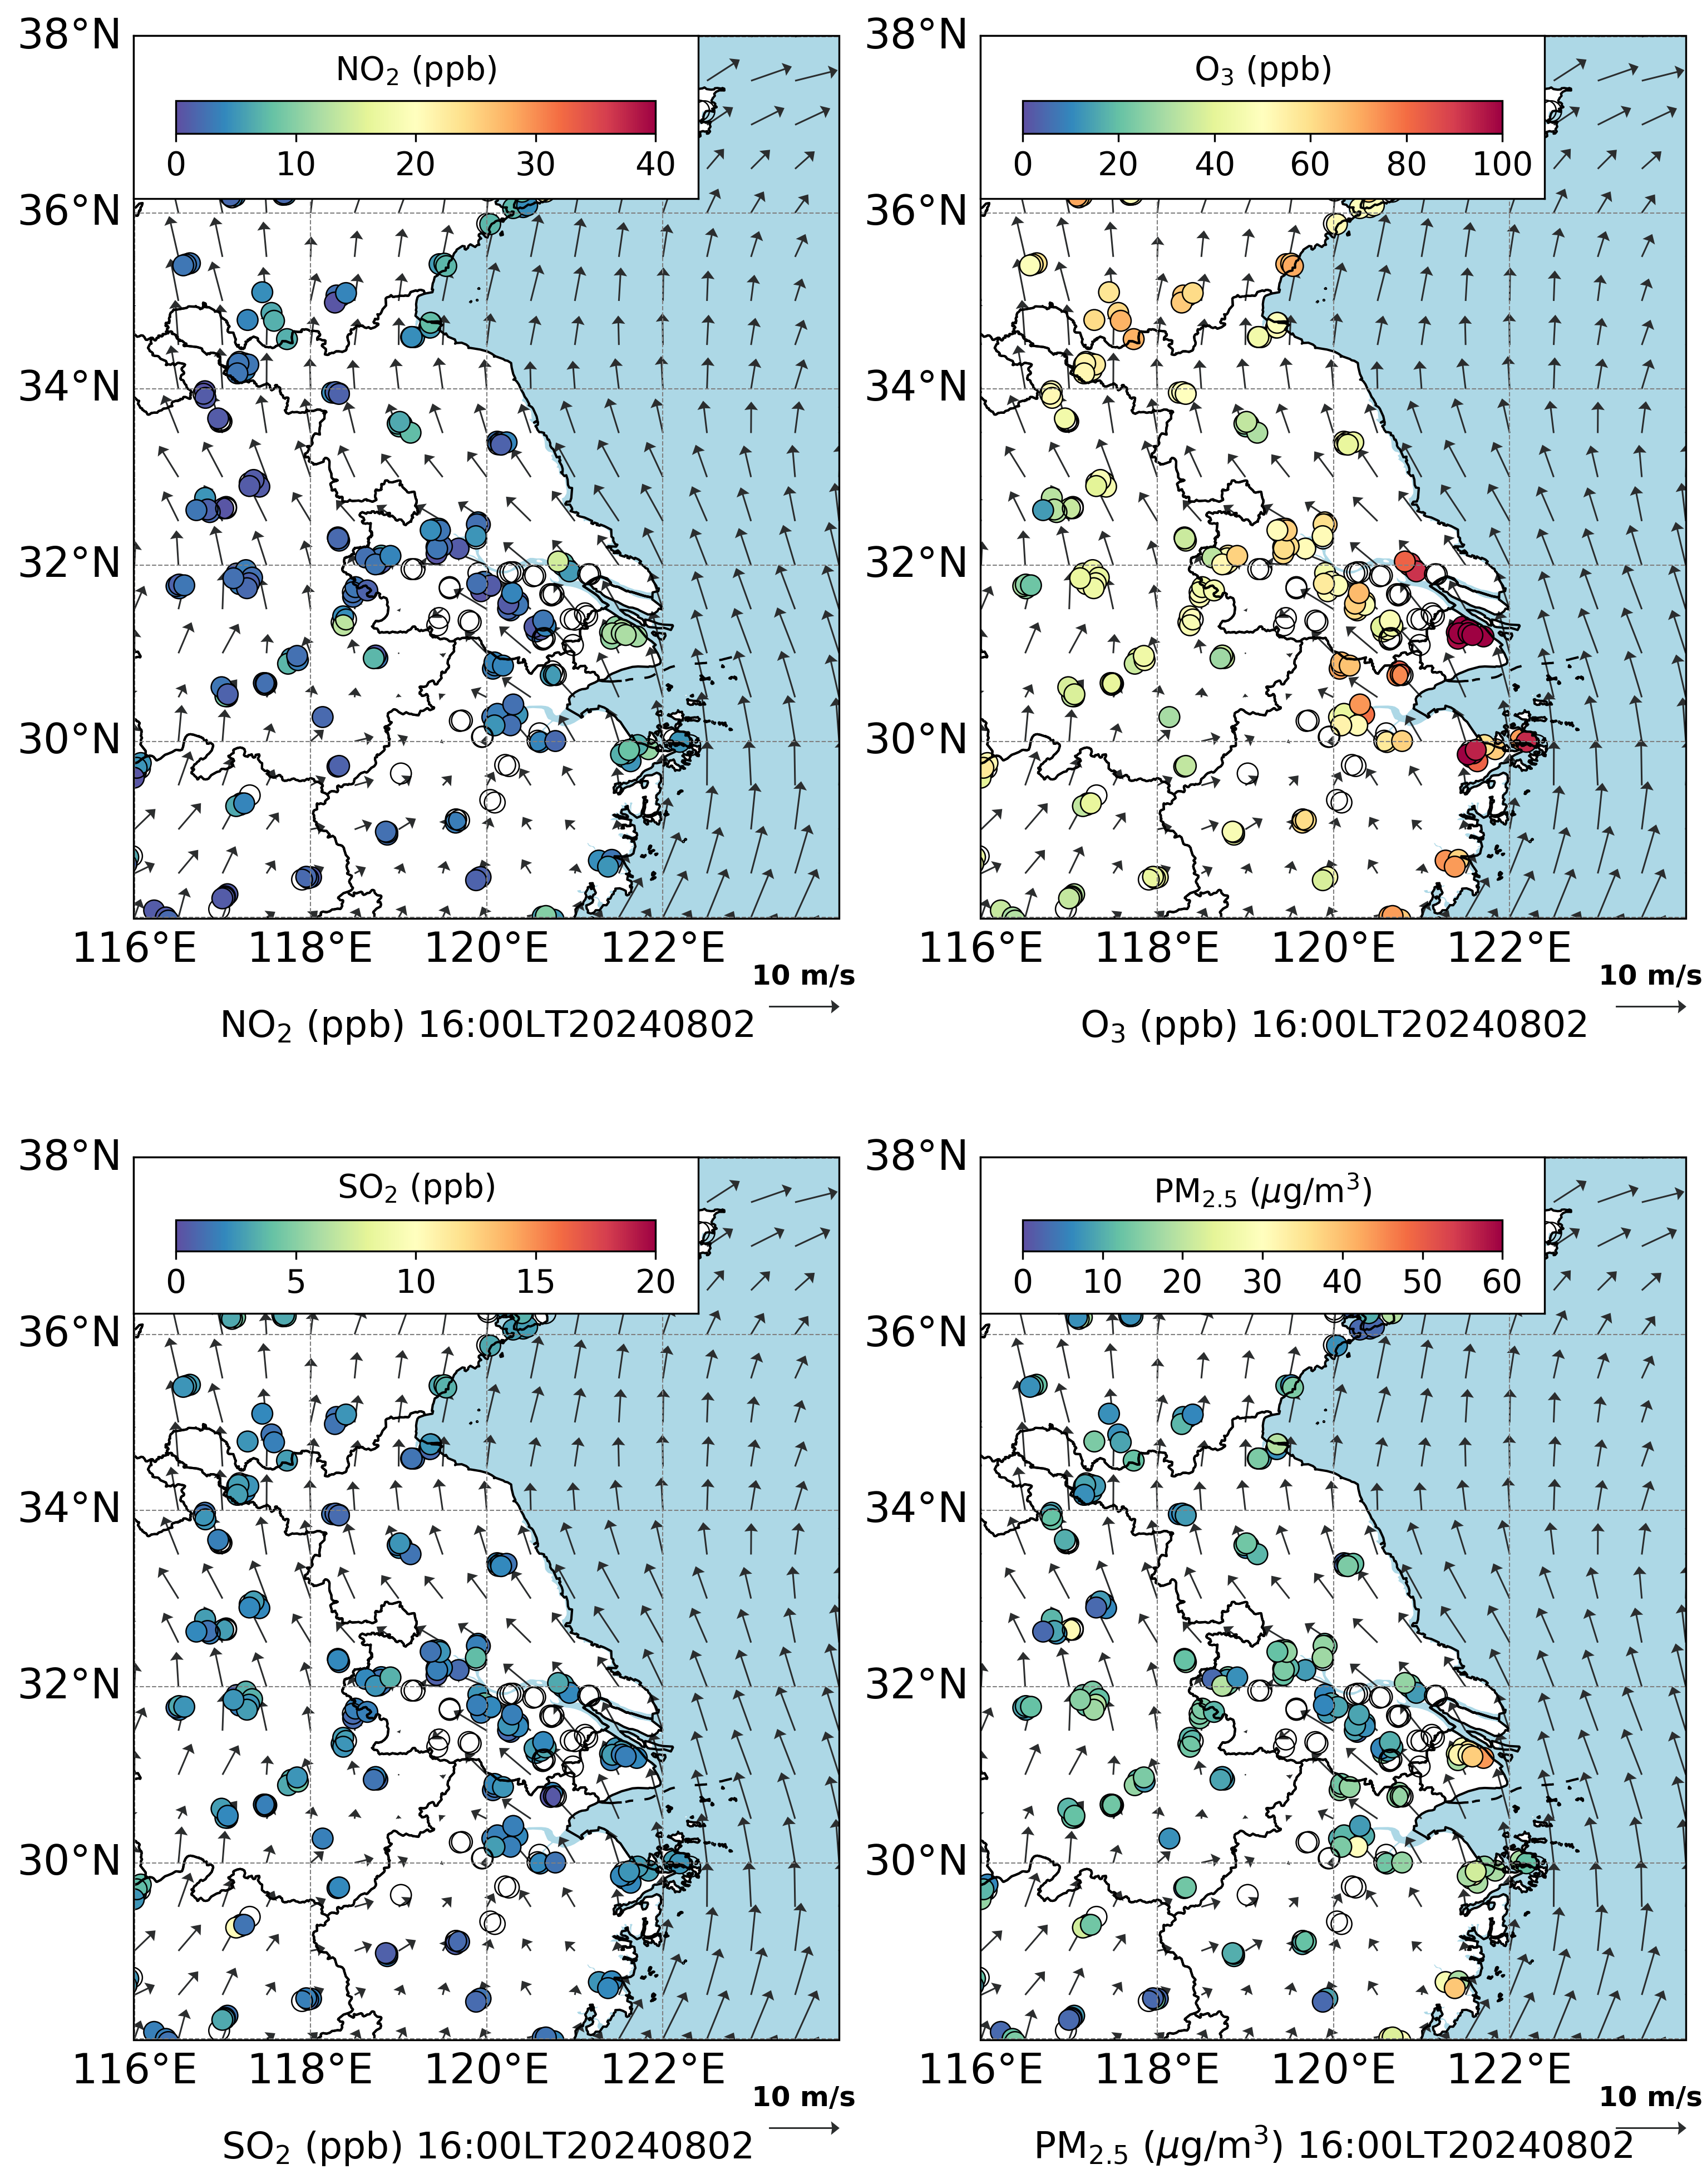

In [62]:
interval = 2

u100 = era5_uv['u100'].sel(valid_time=time)
v100 = era5_uv['v100'].sel(valid_time=time)
lon_uv = u100.longitude.values
lat_uv = u100.latitude.values
lon_uv_grid, lat_uv_grid = np.meshgrid(lon_uv, lat_uv)

fig = plt.figure(figsize=(12, 16), dpi=300)
axs = fig.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()})

for i in range(2):
    for j in range(2):  
        add_shapefile(axs[i, j])
        axs[i, j].set_extent([116-0.01, 124, 28-0.01, 38+0.01])
        axs[i, j].tick_params(labelsize=20)
        qv = axs[i, j].quiver(lon_uv_grid[::interval, ::interval], lat_uv_grid[::interval, ::interval],
                  u100.values[::interval, ::interval], v100.values[::interval, ::interval],
                  transform=ccrs.PlateCarree(),
                  color='#2B2D2E', alpha=1, scale=100, headwidth=8)
        axs[i, j].quiverkey(qv, 0.95, -0.1, 10, '10 m/s',
                     labelpos='N', color='#2B2D2E',
                     fontproperties={'size': 12, 'weight': 'bold'})
    
sc1 = axs[0][0].scatter(stationlist['lon'], stationlist['lat'], c=no2.loc[timestamp],
               vmin=0, vmax=40, cmap='Spectral_r',
               s=80, marker='o', edgecolor='k', linewidth=0.6)
sc2 = axs[0][1].scatter(stationlist['lon'], stationlist['lat'], c=o3.loc[timestamp],
               vmin=0, vmax=100, cmap='Spectral_r',
               s=80, marker='o', edgecolor='k', linewidth=0.6)
sc3 = axs[1][0].scatter(stationlist['lon'], stationlist['lat'], c=so2.loc[timestamp],
               vmin=0, vmax=20, cmap='Spectral_r',
               s=80, marker='o', edgecolor='k', linewidth=0.6)
sc4 = axs[1][1].scatter(stationlist['lon'], stationlist['lat'], c=pm25.loc[timestamp],
               vmin=0, vmax=60, cmap='Spectral_r',
               s=80, marker='o', edgecolor='k', linewidth=0.6)


# add colorbar ax
def add_colorbar_axes_up(fig, ax):
    """
    在主图上方添加一个带白色背景的colorbar区域
    Add a colorbar area with white background above the main plot
    """
    pos = ax.get_position()
    
    # 创建一个新的白色背景子图用于放置colorbar
    cbar_ax = fig.add_axes([pos.x0, pos.y1*0.93, pos.width*0.8, pos.y1*0.07])
    cbar_ax.patch.set_facecolor('white')  # 设置背景为白色
    cbar_ax.set_xticks([])  # 移除刻度
    cbar_ax.set_yticks([])
    
    # 在新子图内部创建一个小一点的区域用于真正的colorbar
    cbar_width = 0.85  # colorbar宽度占比
    cbar_height = 0.2  # colorbar高度占比
    cbar_pos = cbar_ax.get_position()
    colorbar_axes = fig.add_axes([
        cbar_pos.x0 + cbar_pos.width*(1-cbar_width)/2,
        cbar_pos.y0 + cbar_pos.height*(1-cbar_height)/2, 
        cbar_pos.width*cbar_width,
        cbar_pos.height*cbar_height
    ])
    
    return colorbar_axes

def add_colorbar_axes_down(fig, ax):
    """
    在主图上方添加一个带白色背景的colorbar区域
    Add a colorbar area with white background above the main plot
    """
    pos = ax.get_position()
    
    # 创建一个新的白色背景子图用于放置colorbar
    cbar_ax = fig.add_axes([pos.x0, pos.y1*0.87, pos.width*0.8, pos.y1*0.13])
    cbar_ax.patch.set_facecolor('white')  # 设置背景为白色
    cbar_ax.set_xticks([])  # 移除刻度
    cbar_ax.set_yticks([])
    
    # 在新子图内部创建一个小一点的区域用于真正的colorbar
    cbar_width = 0.85  # colorbar宽度占比
    cbar_height = 0.2  # colorbar高度占比
    cbar_pos = cbar_ax.get_position()
    colorbar_axes = fig.add_axes([
        cbar_pos.x0 + cbar_pos.width*(1-cbar_width)/2,
        cbar_pos.y0 + cbar_pos.height*(1-cbar_height)/2, 
        cbar_pos.width*cbar_width,
        cbar_pos.height*cbar_height
    ])
    
    return colorbar_axes

colorbar1 = add_colorbar_axes_up(fig, axs[0][0])
cbar = fig.colorbar(sc1, cax=colorbar1, orientation='horizontal')
cbar.set_label(r'NO$_2$ (ppb)', fontsize=14, labelpad=-55)
cbar.set_ticks(np.arange(0, 40+1, 10))
cbar.set_ticklabels(cbar.get_ticks(), fontsize=14)

colorbar2 = add_colorbar_axes_up(fig, axs[0][1])
cbar2 = fig.colorbar(sc2, cax=colorbar2, orientation='horizontal')
cbar2.set_label(r'O$_3$ (ppb)', fontsize=14, labelpad=-55)
cbar2.set_ticks(np.arange(0, 100+1, 20))
cbar2.set_ticklabels(cbar2.get_ticks(), fontsize=14)

colorbar3 = add_colorbar_axes_down(fig, axs[1][0])
cbar3 = fig.colorbar(sc3, cax=colorbar3, orientation='horizontal')
cbar3.set_label(r'SO$_2$ (ppb)', fontsize=14, labelpad=-55)
cbar3.set_ticks(np.arange(0, 20+1, 5))
cbar3.set_ticklabels(cbar3.get_ticks(), fontsize=14)

colorbar4 = add_colorbar_axes_down(fig, axs[1][1])
cbar4 = fig.colorbar(sc4, cax=colorbar4, orientation='horizontal')
cbar4.set_label(r'PM$_{2.5}$ ($\mu$g/m$^3$)', fontsize=14, labelpad=-55)
cbar4.set_ticks(np.arange(0, 60+1, 10))
cbar4.set_ticklabels(cbar4.get_ticks(), fontsize=14)


title1 = r'NO$_2$ (ppb) '+ timestamp.strftime('%H:%M') + 'LT' + timestamp.strftime('%Y%m%d')
title2 = r'O$_3$ (ppb) '+ timestamp.strftime('%H:%M') + 'LT' + timestamp.strftime('%Y%m%d')
axs[0][0].set_title(title1, fontsize=16, y=-0.15)
axs[0][1].set_title(title2, fontsize=16, y=-0.15)

title3 = r'SO$_2$ (ppb) '+ timestamp.strftime('%H:%M') + 'LT' + timestamp.strftime('%Y%m%d')
title4 = r'PM$_{2.5}$ ($\mu$g/m$^3$) '+ timestamp.strftime('%H:%M') + 'LT' + timestamp.strftime('%Y%m%d')
axs[1][0].set_title(title3, fontsize=16, y=-0.15)
axs[1][1].set_title(title4, fontsize=16, y=-0.15)

# plt.tight_layout()
# plt.savefig(os.path.join('./', 'AQI.png'),bbox_inches='tight', dpi=300)
# plt.close()
# plt.subplots_adjust(wspace=0.2, hspace=0.15)
plt.show()

In [23]:
offset_hours = pd.Timedelta(hours=8)
offset_hours

Timedelta('0 days 08:00:00')

In [27]:
# 读取公共目录下的ERA5 100m UV风场和中国地面观测站点AQI数据
# 根据指定时间范围，批量绘制风场和AQI叠加图(2x2:NO2,O3,SO2,PM2.5)
# 每天生成2张图，白天(10-16)和夜间(22-04)
# 图片命名为yyyymmdd-daytime.png or yyyymmdd-nighttime.png

# Yifei Xu, 2025-04-08
# -----------------------------------------------------------

# User Defined Variables
PLOT_DATE = '2024-08-06'
UTC_OFFSET = 8  # Beijing time is UTC+8

# 用户定义的白天和夜间时间范围
DAYTIME_START = 10  # 白天开始时间 (小时)
DAYTIME_END = 16    # 白天结束时间 (小时)
NIGHTTIME_START = 22  # 夜间开始时间 (小时)
NIGHTTIME_END = 4     # 夜间结束时间 (小时)
NIGHTTIME_NEXT_DAY = True  # 夜间结束时间是否在第二天

import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from datetime import datetime, timedelta

timestamp = pd.Timestamp(PLOT_DATE)
year = timestamp.year
month = timestamp.month
month_str = f"{month:02d}"
year_str = str(year)

# Data Directory
era5_uv_dir = '/data4/PUB_DATA_ALL/Reanalysis/ERA5/hourly_surface/100m_uv'
aqi_dir = '/data4/PUB_DATA_ALL/Observation/AQI_station'
shapefilepath = '/data8/xuyf/data/shapefile/GS(2024)0650-SHP/'

# 获取站点信息
stationlist = pd.read_csv(os.path.join(aqi_dir, 'stationlist.csv'))
stationlist.columns = ['stationID', 'name', 'city', 'lon', 'lat']

# 处理ERA5风场数据 - ERA5是UTC时间，需要转换为本地时间
era5_uv_file = os.path.join(era5_uv_dir, f'ERA5_hourly_100m_uv_{year}-{month_str}.nc')
era5_uv_ds = xr.open_dataset(era5_uv_file)

# 创建本地时间的日期对象，用于选择ERA5数据
# 更稳健的时间转换方法，使用timedelta进行时区转换
base_date = pd.Timestamp(PLOT_DATE)
offset_hours = pd.Timedelta(hours=UTC_OFFSET)

# 白天时段对应的本地时间和UTC时间
daytime_start_local = pd.Timestamp(f'{PLOT_DATE} {DAYTIME_START:02d}:00:00')
daytime_end_local = pd.Timestamp(f'{PLOT_DATE} {DAYTIME_END:02d}:00:00')
daytime_start_utc = daytime_start_local - offset_hours
daytime_end_utc = daytime_end_local - offset_hours

# 夜间时段对应的本地时间和UTC时间
nighttime_start_local = pd.Timestamp(f'{PLOT_DATE} {NIGHTTIME_START:02d}:00:00')

# 处理夜间结束时间是否在第二天
if NIGHTTIME_NEXT_DAY:
    next_day = (base_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
    nighttime_end_local = pd.Timestamp(f'{next_day} {NIGHTTIME_END:02d}:00:00')
else:
    nighttime_end_local = pd.Timestamp(f'{PLOT_DATE} {NIGHTTIME_END:02d}:00:00')

# 转换为UTC时间
nighttime_start_utc = nighttime_start_local - offset_hours
nighttime_end_utc = nighttime_end_local - offset_hours

# 根据UTC时间选择ERA5数据
# ERA5数据的时间维度名是'valid_time'
era5_uv_daytime = era5_uv_ds.sel(valid_time=slice(daytime_start_utc, daytime_end_utc))
era5_uv_nighttime = era5_uv_ds.sel(valid_time=slice(nighttime_start_utc, nighttime_end_utc))

# 提取经纬度网格
lon_uv = era5_uv_ds.longitude.values
lat_uv = era5_uv_ds.latitude.values
lon_uv_grid, lat_uv_grid = np.meshgrid(lon_uv, lat_uv)

# 计算白天和夜间风场的平均值
u100_daytime = era5_uv_daytime['u100'].mean(dim='valid_time')
v100_daytime = era5_uv_daytime['v100'].mean(dim='valid_time')

u100_nighttime = era5_uv_nighttime['u100'].mean(dim='valid_time')
v100_nighttime = era5_uv_nighttime['v100'].mean(dim='valid_time')

# 处理AQI数据
# 创建用于存储不同污染物数据的DataFrame，按照时间索引和站点列名组织
# 这里使用本地时间
timeindex_daytime = pd.date_range(start=daytime_start_local, 
                                 end=daytime_end_local, 
                                 freq='h')
timeindex_nighttime = pd.date_range(start=nighttime_start_local, 
                                   end=nighttime_end_local, 
                                   freq='h')

# 初始化白天和夜间的数据框
daytime_pollutants = {
    'pm25': pd.DataFrame(index=timeindex_daytime, columns=stationlist['stationID'].tolist()),
    'pm10': pd.DataFrame(index=timeindex_daytime, columns=stationlist['stationID'].tolist()),
    'so2': pd.DataFrame(index=timeindex_daytime, columns=stationlist['stationID'].tolist()),
    'no2': pd.DataFrame(index=timeindex_daytime, columns=stationlist['stationID'].tolist()),
    'co': pd.DataFrame(index=timeindex_daytime, columns=stationlist['stationID'].tolist()),
    'o3': pd.DataFrame(index=timeindex_daytime, columns=stationlist['stationID'].tolist())
}

nighttime_pollutants = {
    'pm25': pd.DataFrame(index=timeindex_nighttime, columns=stationlist['stationID'].tolist()),
    'pm10': pd.DataFrame(index=timeindex_nighttime, columns=stationlist['stationID'].tolist()),
    'so2': pd.DataFrame(index=timeindex_nighttime, columns=stationlist['stationID'].tolist()),
    'no2': pd.DataFrame(index=timeindex_nighttime, columns=stationlist['stationID'].tolist()),
    'co': pd.DataFrame(index=timeindex_nighttime, columns=stationlist['stationID'].tolist()),
    'o3': pd.DataFrame(index=timeindex_nighttime, columns=stationlist['stationID'].tolist())
}

# 读取每个站点的AQI数据并处理
for station_id in stationlist['stationID']:
    aqi_file = os.path.join(aqi_dir, f'{year_str}/AQI_{station_id}_{year_str}.txt')
    if os.path.exists(aqi_file):
        # 读取AQI数据
        aqi_data = pd.read_csv(aqi_file, sep=r'\s+', na_values='-999')
        aqi_data['datetime'] = pd.to_datetime(aqi_data['Time'], format='%Y%m%d%H')
        aqi_data = aqi_data.set_index('datetime').drop(columns=['Time'])
        
        # 单位转换
        aqi_data['O3(ppb)'] = aqi_data['O3'] * 22.4 / 48
        aqi_data['NO2(ppb)'] = aqi_data['NO2'] * 22.4 / 46
        aqi_data['SO2(ppb)'] = aqi_data['SO2'] * 22.4 / 64
        aqi_data['CO(ppm)'] = aqi_data['CO'] * 22.4 / 28
        
        # 提取白天时段的数据
        for timestamp in timeindex_daytime:
            if timestamp in aqi_data.index:
                daytime_pollutants['pm25'].loc[timestamp, station_id] = aqi_data.loc[timestamp, 'PM2.5']
                daytime_pollutants['pm10'].loc[timestamp, station_id] = aqi_data.loc[timestamp, 'PM10']
                daytime_pollutants['so2'].loc[timestamp, station_id] = aqi_data.loc[timestamp, 'SO2(ppb)']
                daytime_pollutants['no2'].loc[timestamp, station_id] = aqi_data.loc[timestamp, 'NO2(ppb)']
                daytime_pollutants['co'].loc[timestamp, station_id] = aqi_data.loc[timestamp, 'CO(ppm)']
                daytime_pollutants['o3'].loc[timestamp, station_id] = aqi_data.loc[timestamp, 'O3(ppb)']
        
        # 提取夜间时段的数据
        for timestamp in timeindex_nighttime:
            if timestamp in aqi_data.index:
                nighttime_pollutants['pm25'].loc[timestamp, station_id] = aqi_data.loc[timestamp, 'PM2.5']
                nighttime_pollutants['pm10'].loc[timestamp, station_id] = aqi_data.loc[timestamp, 'PM10']
                nighttime_pollutants['so2'].loc[timestamp, station_id] = aqi_data.loc[timestamp, 'SO2(ppb)']
                nighttime_pollutants['no2'].loc[timestamp, station_id] = aqi_data.loc[timestamp, 'NO2(ppb)']
                nighttime_pollutants['co'].loc[timestamp, station_id] = aqi_data.loc[timestamp, 'CO(ppm)']
                nighttime_pollutants['o3'].loc[timestamp, station_id] = aqi_data.loc[timestamp, 'O3(ppb)']

# 计算白天和夜间的平均值
daytime_avg = {
    'pm25': daytime_pollutants['pm25'].mean(),
    'pm10': daytime_pollutants['pm10'].mean(),
    'so2': daytime_pollutants['so2'].mean(),
    'no2': daytime_pollutants['no2'].mean(),
    'co': daytime_pollutants['co'].mean(),
    'o3': daytime_pollutants['o3'].mean()
}

nighttime_avg = {
    'pm25': nighttime_pollutants['pm25'].mean(),
    'pm10': nighttime_pollutants['pm10'].mean(),
    'so2': nighttime_pollutants['so2'].mean(),
    'no2': nighttime_pollutants['no2'].mean(),
    'co': nighttime_pollutants['co'].mean(),
    'o3': nighttime_pollutants['o3'].mean()
}

In [47]:
nighttime_avg['pm25']

1001A    24.571429
1002A    29.571429
1003A    22.285714
1004A    23.857143
1005A    22.857143
           ...    
3208A    20.142857
3207A    14.571429
3209A          4.0
3210A    14.166667
3216A    18.428571
Length: 1633, dtype: object